In [ ]:
import jax
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt

from projection_vi import ComponentwiseFlow
from projection_vi.train import iterative_AS_mfvi

In [3]:
d = 10

mean = jnp.zeros(d)
rho = 0.9
cov = rho ** jnp.abs(jnp.arange(d)[:, None] - jnp.arange(d)[None, :])
U_ = jax.random.normal(jax.random.key(0), shape=(d, d))
U_ = jnp.linalg.qr(U_)[0]
cov = U_ @ cov @ U_.T # random rotate

def logp_fn(x):
    return mvn.logpdf(x, mean=mean, cov=cov)
exact_samples = jax.random.multivariate_normal(key=jax.random.key(1), mean=mean, cov=cov, shape=(2000,))


In [4]:
model = ComponentwiseFlow(d=d, num_bins=10, range_min=-10, range_max=10)
params = model.init(jax.random.key(0), jnp.zeros(d))
key = jax.random.key(4)
n_train = 2000
n_val = 2000
key, subkey = jax.random.split(key)
base_samples = jax.random.normal(subkey, (n_train + n_val, d))
val_samples = base_samples[n_train:]
base_samples = base_samples[:n_train]

niter = 7
learning_rate = 0.01
max_iter = 200

In [5]:
def get_mse(samples):
    mse_1 = jnp.mean((jnp.mean(samples, 0) - mean)**2)
    mse_2 = jnp.mean((jnp.mean(samples**2, 0) - jnp.diag(cov))**2)
    return mse_1, mse_2

def make_histogram(samples):
    fig, ax = plt.subplots(1, d, figsize=(2*d, 2))
    for j in range(d):
        ax[j].hist(exact_samples[:, j], 30, density=True, alpha=.5)
        ax[j].hist(samples[:, j], 30, density=True, alpha=.5)

### Random rotation

In [6]:
key, subkey = jax.random.split(key)
samples_hist_random, val_samples_hist_random, validation_results_random = iterative_AS_mfvi(model, logp_fn, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank=0, weighted=False)

2025-04-23 17:41:36.526078: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3861.15it/s]


Iteration: 0 KL: 3.2634168 ESS: 97.63349


2025-04-23 17:41:42.316938: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3954.32it/s]


Iteration: 1 KL: 2.9725666 ESS: 106.40739


2025-04-23 17:41:44.026218: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3914.84it/s]


Iteration: 2 KL: 2.5360289 ESS: 96.45711


2025-04-23 17:41:45.695515: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 4532.15it/s]


Iteration: 3 KL: 2.3537848 ESS: 81.796074


2025-04-23 17:41:47.377187: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 4076.75it/s]


Iteration: 4 KL: 2.2022998 ESS: 33.186745


2025-04-23 17:41:49.057665: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3496.45it/s]


Iteration: 5 KL: 2.096964 ESS: 43.034496


2025-04-23 17:41:50.827190: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3937.56it/s]


Iteration: 6 KL: 1.6935177 ESS: 41.58912


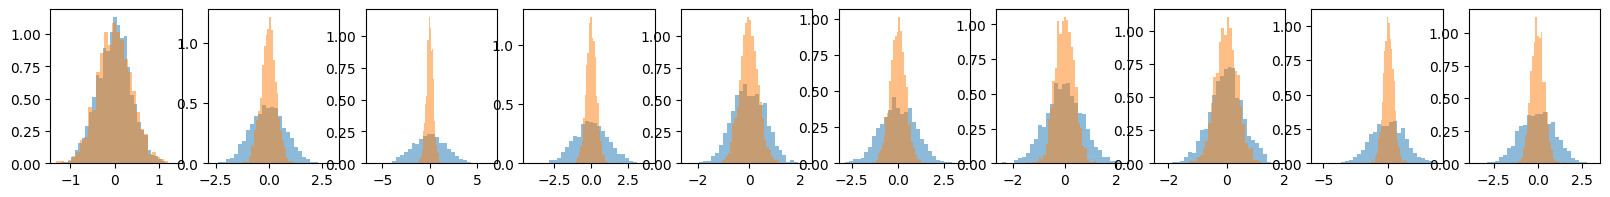

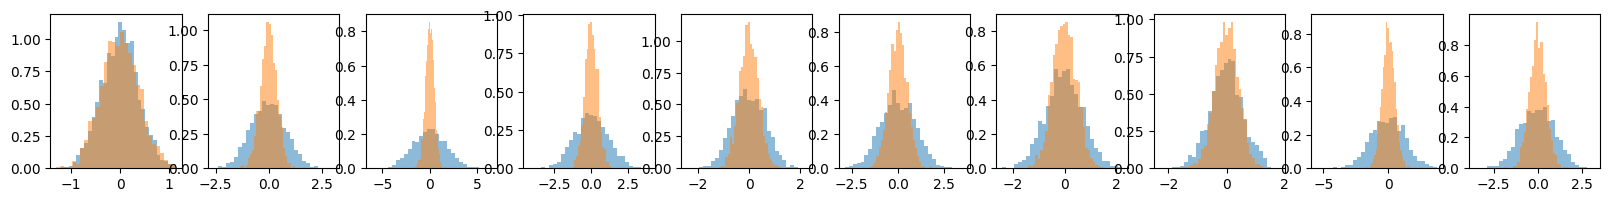

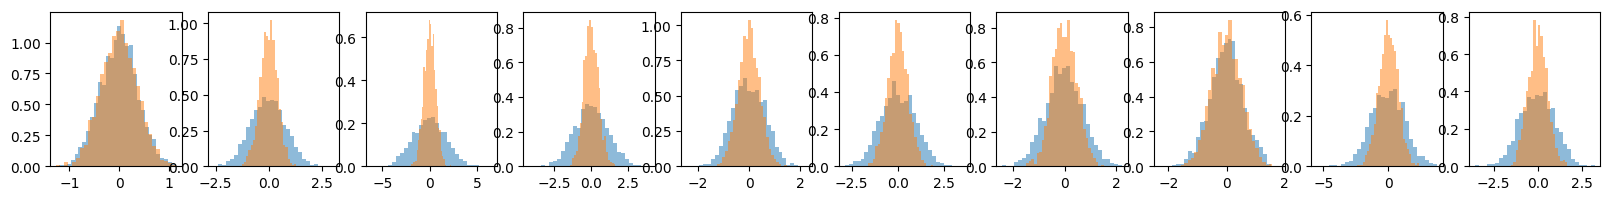

In [7]:
make_histogram(samples_hist_random[0])
make_histogram(samples_hist_random[3])
make_histogram(samples_hist_random[6])

In [15]:
print(get_mse(samples_hist_random[0]))
print(get_mse(samples_hist_random[3]))
print(get_mse(samples_hist_random[6]))

(Array(5.546463e-07, dtype=float32), Array(1.4286493, dtype=float32))
(Array(3.437288e-06, dtype=float32), Array(1.311103, dtype=float32))
(Array(3.3841764e-06, dtype=float32), Array(1.1136653, dtype=float32))


### Rotation by active subspace

Top $r$ principal components, concatenated with random orthogonal complements

In [9]:
key, subkey = jax.random.split(key)
AS_samples_hist, AS_val_samples_hist, validation_results_AS = iterative_AS_mfvi(model, logp_fn, niter=niter, key=subkey, base_samples=base_samples, val_samples=val_samples, learning_rate=learning_rate, max_iter=max_iter, rank=6, weighted=False)

2025-04-23 17:42:24.627508: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3930.56it/s]


eigenvalues [21.169518   16.03498    13.503792    7.6102414   4.8348446   2.5400739
  1.7273631   1.3573693   0.14546368  0.05396216]
Iteration: 0 KL: 1.1519179 ESS: 174.5244


2025-04-23 17:42:34.597647: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3795.01it/s]


eigenvalues [16.965633   12.936816   11.510905    6.1489387   4.5807166   2.9349291
  0.9431397   0.3673211   0.27933186  0.08473885]
Iteration: 1 KL: 0.73109645 ESS: 173.61188


2025-04-23 17:42:36.477918: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3846.08it/s]


eigenvalues [14.973139   12.669123   11.063658    5.156697    3.6765914   3.019296
  0.5603898   0.45124763  0.16629164  0.06315425]
Iteration: 2 KL: 0.52772176 ESS: 299.85858


2025-04-23 17:42:38.394175: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3814.11it/s]


eigenvalues [13.034867   12.543486   10.920344    4.259078    3.7620218   2.683666
  0.6162312   0.46586582  0.16421477  0.09567557]
Iteration: 3 KL: 0.49362296 ESS: 254.56119


2025-04-23 17:42:40.329408: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 3949.87it/s]


eigenvalues [12.905969   12.488393   10.733558    3.98543     3.7117634   2.8258271
  0.6353565   0.39516342  0.18367708  0.1333675 ]
Iteration: 4 KL: 0.4523459 ESS: 248.58202


2025-04-23 17:42:42.262106: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 1325.70it/s]


eigenvalues [13.057212   12.538339   10.592752    3.9431303   3.684324    2.8374422
  0.6873014   0.40338334  0.2467408   0.15626535]
Iteration: 5 KL: 0.444073 ESS: 163.41196


2025-04-23 17:42:44.332966: W external/xla/xla/hlo/transforms/host_offloader.cc:372] Token parameters are not supported for streaming.
Running for 200 iterations: 100%|██████████| 200/200 [00:00<00:00, 2059.27it/s]


eigenvalues [13.06325    12.516061   10.43352     3.9527814   3.7344608   2.8737195
  0.7225535   0.37849313  0.33113903  0.2067863 ]
Iteration: 6 KL: 0.41760495 ESS: 148.89105


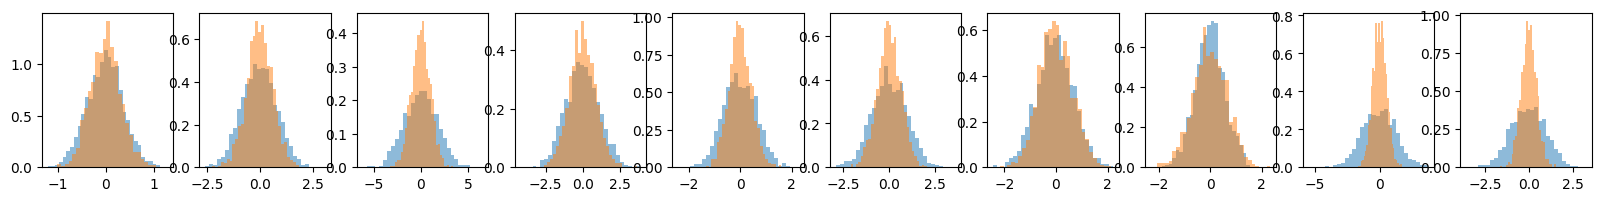

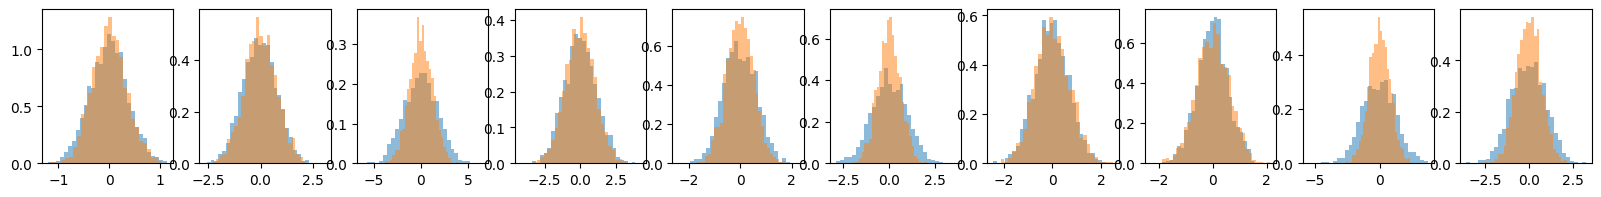

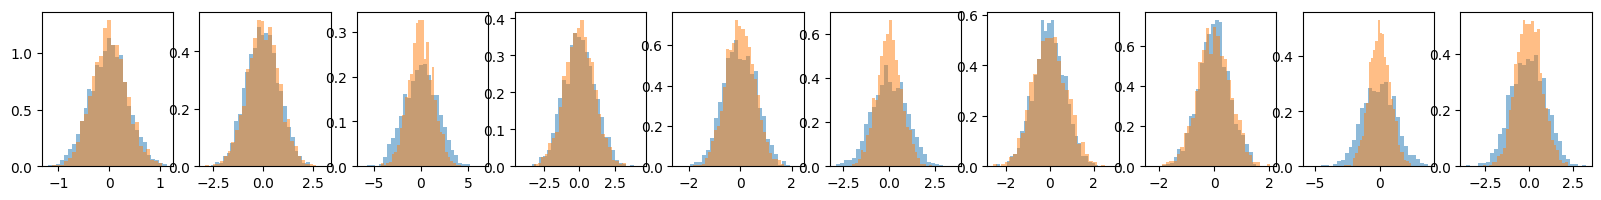

In [11]:
make_histogram(AS_samples_hist[0])
make_histogram(AS_samples_hist[3])
make_histogram(AS_samples_hist[6])

In [14]:
print(get_mse(AS_samples_hist[0]))
print(get_mse(AS_samples_hist[3]))
print(get_mse(AS_samples_hist[6]))

(Array(1.6606011e-06, dtype=float32), Array(0.7890734, dtype=float32))
(Array(6.0462617e-07, dtype=float32), Array(0.4635423, dtype=float32))
(Array(2.486438e-07, dtype=float32), Array(0.37377128, dtype=float32))


Text(0.5, 1.0, 'ESS')

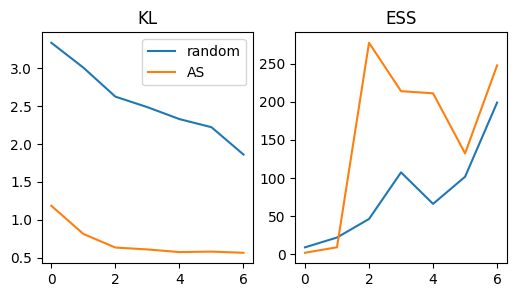

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].plot(validation_results_random['KL'], label='random')
ax[0].plot(validation_results_AS['KL'], label='AS')
ax[0].set_title('KL')
ax[0].legend()

ax[1].plot(validation_results_random['ESS'])
ax[1].plot(validation_results_AS['ESS'])
ax[1].set_title('ESS')